In [8]:
import geopandas as gpd
import pandas as pn
import numpy as np
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show

import solaris as sol
from solaris.data import data_dir

import matplotlib.pyplot as plt
from shapely.ops import unary_union

# %config Completer.use_jedi = True

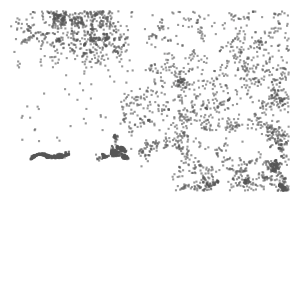

In [3]:
gdf = gpd.read_file("bboxes/bounding_boxes/bounding_boxes.shp").explode()  # explode to make multipolygon single polygon

In [4]:
gdf.head()

,,MAPA,DELEGACIO,MUNICIPIO,MASA,PARCELA,HOJA,TIPO,CONSTRU,COORX,COORY,...,NUM_EXP,CONTROL,REFCAT,layer,path,width,height,area_1,perimeter,geometry
0,0,7016,7,13,013,00574,07013A,R,PI,504323.31,4362849.37,...,None,None,07013A01300574,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,10.5500,10.8400,114.362000,42.780,"POLYGON ((504317.996 4362843.978, 504317.996 4..."
1,0,7016,7,13,018,00577,07013A,R,PI,501581.77,4358058.30,...,None,None,07013A01800577,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,11.8995,11.5495,137.433275,46.898,"POLYGON ((501575.823 4358052.535, 501575.823 4..."
2,0,7016,7,13,006,00292,07013A,R,PI,498261.83,4366232.32,...,None,None,07013A00600292,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,6.7460,6.4820,43.727572,26.456,"POLYGON ((498258.454 4366229.060, 498258.454 4..."
3,0,7016,7,13,007,00062,07013A,R,PI,500855.04,4365573.30,...,None,None,07013A00700062,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,4.4900,7.4900,33.630100,23.960,"POLYGON ((500852.790 4365569.800, 500852.790 4..."
4,0,7016,7,13,002,00394,07013A,R,PI,496901.39,4362554.24,...,None,None,07013A00200394,campos_r,/home/biel/Documents/Master/TFM/cadastre/extra...,8.1490,6.7800,55.250220,29.858,"POLYGON ((496897.317 4362550.844, 496897.317 4..."


In [5]:
gdf.columns

Index(['MAPA', 'DELEGACIO', 'MUNICIPIO', 'MASA', 'PARCELA', 'HOJA', 'TIPO',
       'CONSTRU', 'COORX', 'COORY', 'NUMSYMBOL', 'AREA', 'FECHAALTA',
       'FECHABAJA', 'NINTERNO', 'PCAT1', 'PCAT2', 'EJERCICIO', 'NUM_EXP',
       'CONTROL', 'REFCAT', 'layer', 'path', 'width', 'height', 'area_1',
       'perimeter', 'geometry'],
      dtype='object')

In [13]:
bbox = gdf.geometry[31]
img_path = "/media/biel/SharedHDD/Master/TFM/ortos/PNOA_MA_OF_ETRS89_HU31_h50_0698_test.tif"
with rasterio.open(img_path) as src:
    window = rasterio.windows.from_bounds(*bbox.bounds.values[0], src.transform)
#     window.width, window.height = 512, 512
    img = src.read(window=window)
    print(src.tags())

{'AREA_OR_POINT': 'Area', 'COLORSPACE': 'RGB', 'COMPRESSION_RATE_TARGET': '6', 'VERSION': '2'}


ValueError: zero-size array to reduction operation minimum which has no identity

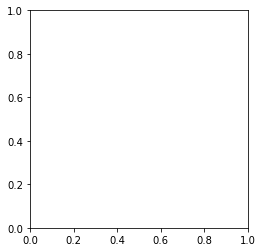

In [14]:
show(img)

In [6]:
rasterio.windows.transform(window, src.transform)

Affine(0.15, 0.0, 497858.7685,
       0.0, -0.15, 4363448.4875)

In [7]:
src.transform

Affine(0.15, 0.0, 483790.0,
       0.0, -0.15, 4372340.0)

In [8]:
src.transform * (window.col_off, window.row_off)

(497858.7685, 4363448.4875)

In [9]:
window.col_off

93791.79000000004

### Tiling

TODO: make windows with overlap

Used this to generate 521x512 tiles into `0724_tiles` folder.
```python
from solaris.tile.raster_tile import RasterTiler
from solaris.tile.vector_tile import VectorTiler

rtiler = RasterTiler(dest_dir="./0724_tiles", src_tile_size=(512, 512), verbose=True, nodata=0)
# skip images that have 90% of nodata
r_bounds = rtiler.tile(img_path, nodata_threshold=0.9)
```

In [10]:
from pathlib import Path
import numpy as np
import random
from shapely.geometry import box

In [11]:
tiles = list(Path("yolo_data/tiles/").glob("*.tif"))
tiles_sub = random.sample(tiles, 16)

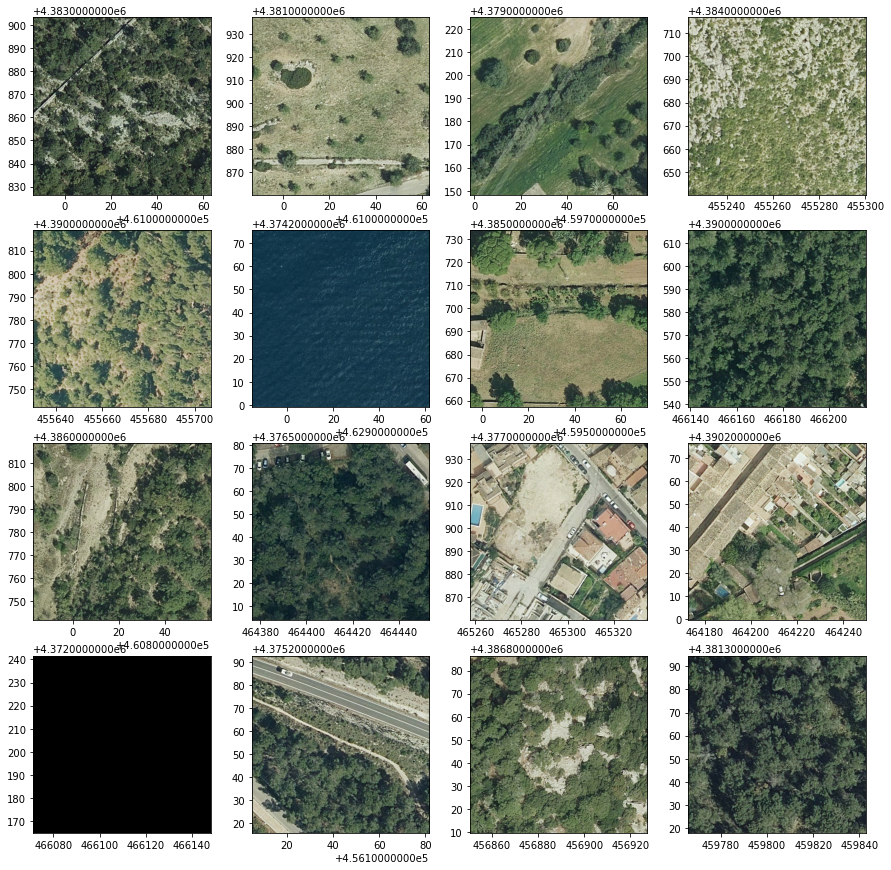

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i, ax in enumerate(axs.ravel()):
    with rasterio.open(str(tiles_sub[i])) as f:
        show(f, ax=ax)

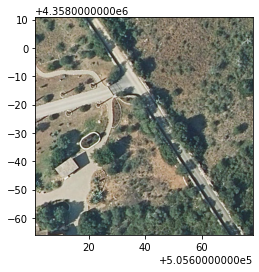

In [13]:
poolim = str(tiles_sub[8])
with rasterio.open(poolim) as f:
    bounds = f.bounds
    show(f)

In [14]:
from solaris.vector.polygon import convert_poly_coords, get_overlapping_subset

In [15]:
any(g.intersects(box(*bounds)) for g in gdf.geometry)

False

In [16]:
sol.vector.polygon.get_overlapping_subset(gdf, im=poolim)

,,MAPA,DELEGACIO,MUNICIPIO,MASA,PARCELA,HOJA,TIPO,CONSTRU,COORX,COORY,...,NUM_EXP,CONTROL,REFCAT,layer,path,width,height,area_1,perimeter,geometry


In [17]:
from tqdm.notebook import tqdm
import numba

In [18]:
res = sol.vector.polygon.convert_poly_coords(gdf.iloc[3028].geometry, raster_src=poolim, inverse=True)

In [19]:
res.bounds

(14636.099271356594,
 15622.501468662173,
 14699.766079853289,
 15696.701633956283)

In [9]:
def bbox_to_yolo(box: tuple, size: tuple=(512, 512)) -> tuple:
    """Converts bounding box coordinates (minx, miny, maxx, maxy) to yolo (x, y, w, h)"""
    dw = 1./size[0]
    dh = 1./size[1]
    x = ((box[0] + box[2])/2.0) * dw
    y = ((box[1] + box[3])/2.0) * dh
    w = (box[2] - box[0]) * dw
    h = (box[3] - box[1]) * dh
    return (x,y,w,h)

def trim_box(box: tuple, size: tuple=(512, 512)) -> tuple:
    """trims box coordinates (minx, miny, maxx, maxy) to the images edges given the image size (w, h)"""
    x0, y0, x1, y1 = box
    w, h = size
    c_x0, c_x1 = np.clip([x0, x1], 0, w)
    c_y0, c_y1 = np.clip([y0, y1], 0, h)    
    return c_x0, c_y0, c_x1, c_y1

In [28]:
yolo_coords = []
imgs_w_pools = []
for im in tqdm(tiles):
    with rasterio.open(im) as src:
        sub = get_overlapping_subset(gdf, src)
        if not sub.empty:
            for geom in sub.geometry:
                imgs_w_pools.append(im)
                pix_coords = convert_poly_coords(geom, raster_src=src, inverse=True)
                yolo_coords.append(bbox_to_yolo(trim_box(pix_coords.bounds)))

  0%|          | 0/91368 [00:00<?, ?it/s]

In [52]:
seen = set()
imgs_w_2 = set()
for im, coords in zip(imgs_w_pools, yolo_coords):
    f_name = im.name.split(".tif")[0] + ".txt"
    # set append mode if file already exists -> more than one pool per image
    if f_name in seen:
        mode = "a"
        imgs_w_2.add(im)
    else:
        mode = "w"
    with open(f"yolo_labels/{f_name}", mode) as f:
        f.write("0 " + " ".join(map(str, coords)) + "\n")
    seen.add(f_name)

In [53]:
imgs_w_2 = list(imgs_w_2)

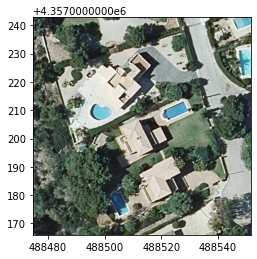

In [54]:
with rasterio.open(imgs_w_2[16]) as f:
    show(f)

In [55]:
imgs_w_2[16]

PosixPath('0724_tiles/PNOA_MA_OF_ETRS89_HU31_h50_0724_test_488474_4357242.tif')